In [2]:
import os
import json
import torch
from torch.utils.tensorboard import SummaryWriter
from utils import rinomina_classi_in_dir, undersample_dataset, count_images_per_class, split_train_val_test
from data_loader import get_data_loaders
from model import CustomCNN, TransferMobileNet
from train import train_model
from evaluate import evaluate_model, plot_training
from jsonschema import validate
import jsonschema

In [3]:
# Caricamento del file di configurazione
with open('config.json', 'r') as f:
    config = json.load(f)

In [4]:
# Caricamento del JSON Schema
with open('config_schema.json', 'r') as f:
    schema = json.load(f)

    # Validazione della configurazione
try:
    validate(instance=config, schema=schema)
    print("✅ Configurazione valida.")
except jsonschema.exceptions.ValidationError as err:
    print("❌ Errore nella configurazione:", err)
    raise

✅ Configurazione valida.


In [5]:
# Usa path fissi coerenti con la struttura delle cartelle che hai
original_dir = config.get("original_data_path", "./Dataset/PlantVillage")
balanced_dir = config.get("balanced_data_path", "./Dataset/PlantVillage_balanced")
split_dir = config.get("split_data_path", "./Dataset/PlantVillage_split")

train_dir = config["train_data_path"]  # "./Dataset/PlantVillage_split/train"
val_dir = config["val_data_path"]      # "./Dataset/PlantVillage_split/val"
test_dir = config["test_data_path"]    # "./Dataset/PlantVillage_split/test"

batch_size = config.get("batch_size", 32)
val_ratio = 0.15     
test_ratio = 0.15      
epochs = config.get("num_epochs", 50)
learning_rate = config.get("learning_rate", 0.001)
target_accuracy = config.get("target_accuracy", 0.95)
early_stopping_patience = config.get("early_stopping_patience", 10)

print(f"Original data dir: {original_dir}")
print(f"Balanced data dir: {balanced_dir}")
print(f"Split data dir: {split_dir}")
print(f"Training dir (loader): {train_dir}")
print(f"Validation dir (loader): {val_dir}")



Original data dir: ./Dataset/PlantVillage
Balanced data dir: ./Dataset/PlantVillage_balanced
Split data dir: ./Dataset/PlantVillage_split
Training dir (loader): ./Dataset/PlantVillage_split/train
Validation dir (loader): ./Dataset/PlantVillage_split/val


In [6]:
# Rinomina classi
rinomina_classi_in_dir(original_dir)

In [7]:
# Undersampling per bilanciare
undersample_dataset(original_dir, balanced_dir, max_per_class=1000)

✅ Dataset ridotto salvato in: ./Dataset/PlantVillage_balanced


In [8]:
# Conta immagini
print("Distribuzione originale:", count_images_per_class(original_dir))
print("Distribuzione bilanciata:", count_images_per_class(balanced_dir))

Distribuzione originale: {'pep_bell_Bacterial_spot': 976, 'pep_bell_healthy': 1478, 'pot_Early_blight': 1000, 'pot_healthy': 152, 'pot_Late_blight': 1000, 'tom_Bacterial_spot': 2127, 'tom_Early_blight': 1000, 'tom_healthy': 1591, 'tom_Late_blight': 1909, 'tom_Leaf_Mold': 952, 'tom_Septoria_leaf_spot': 1771, 'tom_Spider_mites_Two_spotted_spider_mite': 1676, 'tom_Target_Spot': 1404, 'tom_Tomato_mosaic_virus': 373, 'tom_Tomato_YellowLeaf_Curl_Virus': 3208}
Distribuzione bilanciata: {'pep_bell_Bacterial_spot': 976, 'pep_bell_healthy': 1000, 'pot_Early_blight': 1000, 'pot_healthy': 152, 'pot_Late_blight': 1000, 'tom_Bacterial_spot': 1000, 'tom_Early_blight': 1000, 'tom_healthy': 1000, 'tom_Late_blight': 1000, 'tom_Leaf_Mold': 952, 'tom_Septoria_leaf_spot': 1000, 'tom_Spider_mites_Two_spotted_spider_mite': 1000, 'tom_Target_Spot': 1000, 'tom_Tomato_mosaic_virus': 373, 'tom_Tomato_YellowLeaf_Curl_Virus': 1000}


In [9]:
# Split train/val/test
split_train_val_test(balanced_dir, split_dir, val_ratio=val_ratio, test_ratio=test_ratio)
print("Dataset splittato in train/val/test.")

Dataset splittato in train/val/test.


In [10]:
# DataLoader
train_loader, val_loader, class_names = get_data_loaders(split_dir, img_size=(224, 224), batch_size=batch_size)
print(f"Classi: {class_names}")


Classi: ['pep_bell_Bacterial_spot', 'pep_bell_healthy', 'pot_Early_blight', 'pot_Late_blight', 'pot_healthy', 'tom_Bacterial_spot', 'tom_Early_blight', 'tom_Late_blight', 'tom_Leaf_Mold', 'tom_Septoria_leaf_spot', 'tom_Spider_mites_Two_spotted_spider_mite', 'tom_Target_Spot', 'tom_Tomato_YellowLeaf_Curl_Virus', 'tom_Tomato_mosaic_virus', 'tom_healthy']


In [11]:
# Creazione modello e device

model = TransferMobileNet(num_classes=len(class_names))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [ ]:
# Carico il CheckPoint
checkpoint_path = os.path.join(config.get("checkpoint_dir", "./checkpoints"), "model_best.pth")

In [12]:
# Chiamata Training
model, train_losses, val_losses, train_accs, val_accs = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs,
    learning_rate,
    early_stopping_patience=early_stopping_patience,
    target_accuracy=target_accuracy,
    checkpoint_dir=config.get("checkpoint_dir", "./checkpoints"),
    resume_from=None,  
    log_dir=config.get("log_dir", "./runs")
)


Epoch 1/10 - Train loss: 1.4640, Train acc: 0.5772 - Val loss: 0.7180, Val acc: 0.8094
Epoch 2/10 - Train loss: 0.9162, Train acc: 0.7237 - Val loss: 0.5364, Val acc: 0.8496
Epoch 3/10 - Train loss: 0.7792, Train acc: 0.7606 - Val loss: 0.4507, Val acc: 0.8754
Epoch 4/10 - Train loss: 0.7235, Train acc: 0.7680 - Val loss: 0.4340, Val acc: 0.8715
Epoch 5/10 - Train loss: 0.7125, Train acc: 0.7726 - Val loss: 0.3850, Val acc: 0.8888
Epoch 6/10 - Train loss: 0.6700, Train acc: 0.7801 - Val loss: 0.4051, Val acc: 0.8700
Epoch 7/10 - Train loss: 0.6843, Train acc: 0.7817 - Val loss: 0.3731, Val acc: 0.8829
Epoch 8/10 - Train loss: 0.6592, Train acc: 0.7870 - Val loss: 0.3961, Val acc: 0.8675
Epoch 9/10 - Train loss: 0.6521, Train acc: 0.7861 - Val loss: 0.3535, Val acc: 0.8864
Epoch 10/10 - Train loss: 0.6498, Train acc: 0.7853 - Val loss: 0.3541, Val acc: 0.8878


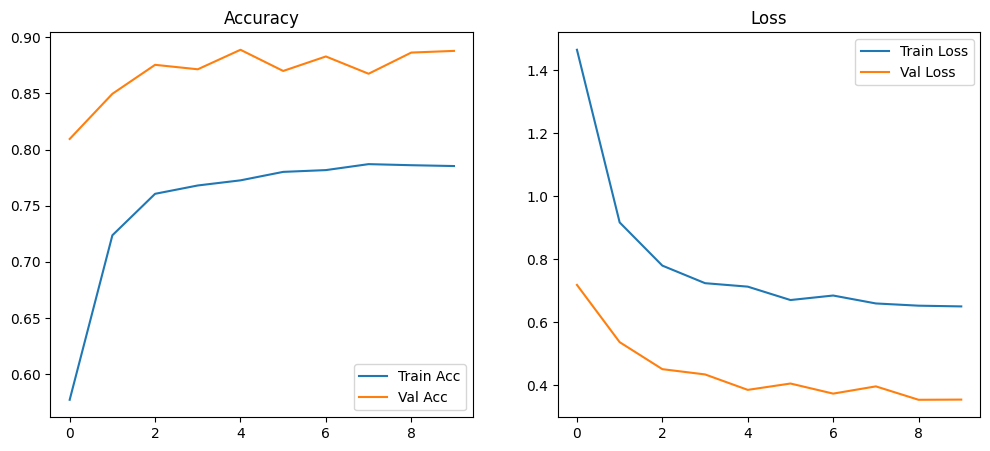

In [16]:
# Step 7 - Visualizza andamento training
plot_training(train_losses, val_losses, train_accs, val_accs)


Classification Report:
                                          precision    recall  f1-score   support

                 pep_bell_Bacterial_spot       0.92      0.97      0.94       146
                        pep_bell_healthy       0.96      0.99      0.98       150
                        pot_Early_blight       0.99      0.98      0.99       150
                         pot_Late_blight       0.98      0.91      0.94       150
                             pot_healthy       0.95      0.91      0.93        22
                      tom_Bacterial_spot       0.87      0.90      0.88       150
                        tom_Early_blight       0.89      0.58      0.70       150
                         tom_Late_blight       0.78      0.89      0.83       150
                           tom_Leaf_Mold       0.78      0.98      0.87       142
                  tom_Septoria_leaf_spot       0.86      0.83      0.84       150
tom_Spider_mites_Two_spotted_spider_mite       0.95      0.77      0.85   

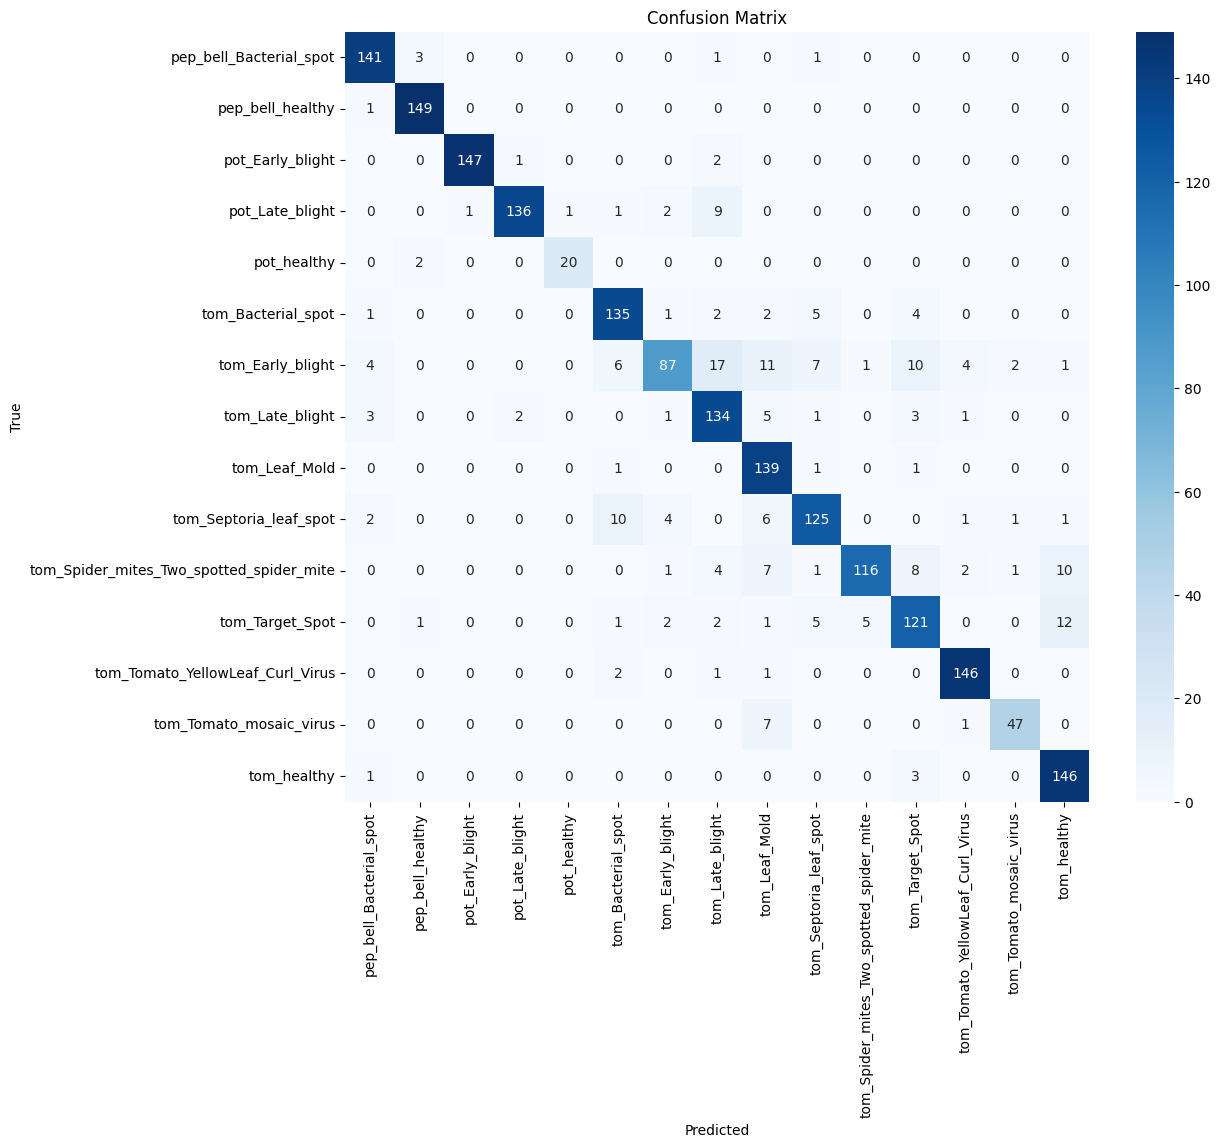

In [17]:
# Step 8 - Valuta il modello su validation set
evaluate_model(model, val_loader, device, class_names)

In [15]:
# Salvataggio Modello finale
torch.save(model.state_dict(), "plantvillage_transfer_model.pth")
print("✅ Modello salvato in plantvillage_transfer_model.pth")

✅ Modello salvato in plantvillage_transfer_model.pth
